# Multi-omics Analysis of scRNA-seq and scATAC-seq Data

This script performs a multi-omics analysis using single-cell RNA sequencing (**scRNA-seq**) and single-cell ATAC sequencing (**scATAC-seq**) datasets from the **GSE126074 study**.
 
The goal is to **integrate transcriptomic and epigenomic data** to uncover cellular heterogeneity and gene regulation.  
The analysis includes **data loading, preprocessing, visualization, and clustering using the MuData framework.**

## Table of Contents
1. [Setup](#setup)
2. [Data Loading](#data-loading)
3. [Data Exploration](#data-exploration)
4. [Data Visualization](#data-visualization)
5. [Data Preprocessing](#data-preprocessing)
6. [Multi-omics Analysis](#multi-omics-analysis)
7. [Clustering and Visualization](#clustering-and-visualization)

## Setup

We first import the necessary libraries for **data processing, visualization, and multi-omics analysis**.

In [1]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import muon as mu
import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading

Here, we define the paths to our scRNA-seq and scATAC-seq files from the GSE126074 dataset. We load both count matrices (.mtx) and their associated metadata like barcodes and feature names (.tsv).

In [2]:
# Get the current directory
current_dir = os.getcwd()

# Define the data path
data_path = os.path.join(current_dir, 'data', 'GSE126074')

# Define the file paths
rna_counts_path = os.path.join(data_path, 'GSE126074_AdBrainCortex_SNAREseq_cDNA.counts.mtx.gz')
rna_barcodes_path = os.path.join(data_path, 'GSE126074_AdBrainCortex_SNAREseq_cDNA.barcodes.tsv.gz')
rna_genes_path = os.path.join(data_path, 'GSE126074_AdBrainCortex_SNAREseq_cDNA.genes.tsv.gz')

atac_counts_path = os.path.join(data_path, 'GSE126074_AdBrainCortex_SNAREseq_chromatin.counts.mtx.gz')
atac_barcodes_path = os.path.join(data_path, 'GSE126074_AdBrainCortex_SNAREseq_chromatin.barcodes.tsv.gz')
atac_peaks_path = os.path.join(data_path, 'GSE126074_AdBrainCortex_SNAREseq_chromatin.peaks.tsv.gz')

# Load scRNA-seq data
adata_rna = sc.read_mtx(rna_counts_path)
barcodes_rna = pd.read_csv(rna_barcodes_path, header=None, sep='\t')
genes_rna = pd.read_csv(rna_genes_path, header=None, sep='\t')

# Load scATAC-seq data
adata_atac = sc.read_mtx(atac_counts_path)
barcodes_atac = pd.read_csv(atac_barcodes_path, header=None, sep='\t')
peaks_atac = pd.read_csv(atac_peaks_path, header=None, sep='\t')

## Data Exploration

Before moving forward, we inspect the **genes** and **peaks** data to understand its structure by printing the first few rows of the DataFrames.

In [3]:
# Print the first few rows of the genes and peaks DataFrames to understand their structure
print("Genes DataFrame:")
print(genes_rna.head())
print("\nPeaks DataFrame:")
print(peaks_atac.head())

Genes DataFrame:
               0
0  0610005C13Rik
1  0610007P14Rik
2  0610009B22Rik
3  0610009E02Rik
4  0610009L18Rik

Peaks DataFrame:
                      0
0  chr1:3005833-3005982
1  chr1:3094772-3095489
2  chr1:3119556-3120739
3  chr1:3121334-3121696
4  chr1:3134637-3135032


## Data Visualization

Next, we **visualize gene expression and peak accessibility distributions** using histograms.

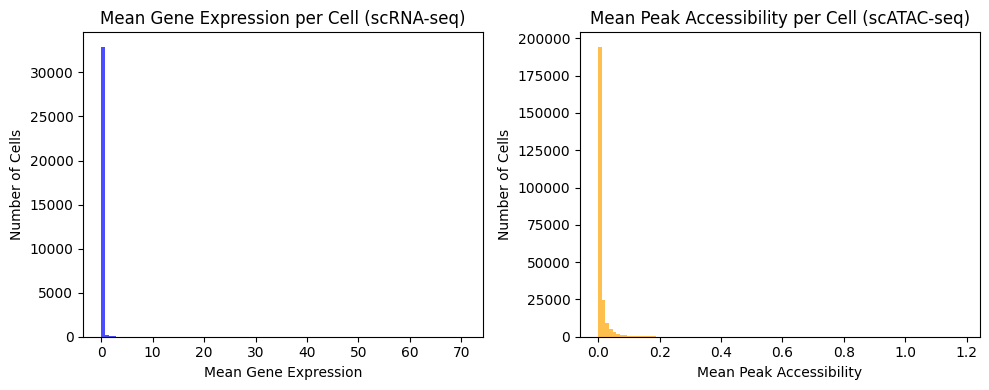

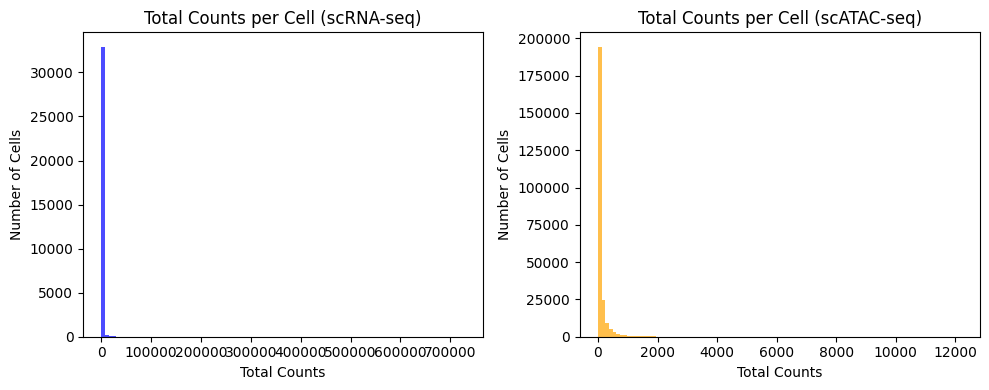

In [4]:
# Plot gene expression distributions for scRNA-seq data
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(adata_rna.X.mean(axis=1), bins=100, alpha=0.7, color='blue')
plt.title('Mean Gene Expression per Cell (scRNA-seq)')
plt.xlabel('Mean Gene Expression')
plt.ylabel('Number of Cells')

# Plot peak accessibility distributions for scATAC-seq data
plt.subplot(1, 2, 2)
plt.hist(adata_atac.X.mean(axis=1), bins=100, alpha=0.7, color='orange')
plt.title('Mean Peak Accessibility per Cell (scATAC-seq)')
plt.xlabel('Mean Peak Accessibility')
plt.ylabel('Number of Cells')
plt.tight_layout()
plt.show()

# Plot total counts per cell for scRNA-seq data
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(adata_rna.X.sum(axis=1), bins=100, alpha=0.7, color='blue')
plt.title('Total Counts per Cell (scRNA-seq)')
plt.xlabel('Total Counts')
plt.ylabel('Number of Cells')

# Plot total counts per cell for scATAC-seq data
plt.subplot(1, 2, 2)
plt.hist(adata_atac.X.sum(axis=1), bins=100, alpha=0.7, color='orange')
plt.title('Total Counts per Cell (scATAC-seq)')
plt.xlabel('Total Counts')
plt.ylabel('Number of Cells')
plt.tight_layout()
plt.show()

**Histogram Interpretation:**

The histograms for **scRNA-seq** and **scATAC-seq** shows a skewed distribution, where most cells exhibit low gene expression or chromatin accessibility, with fewer cells showing higher counts.

**Next Step:**  
We will use **boxplots** to detect **outliers** in the dataset.

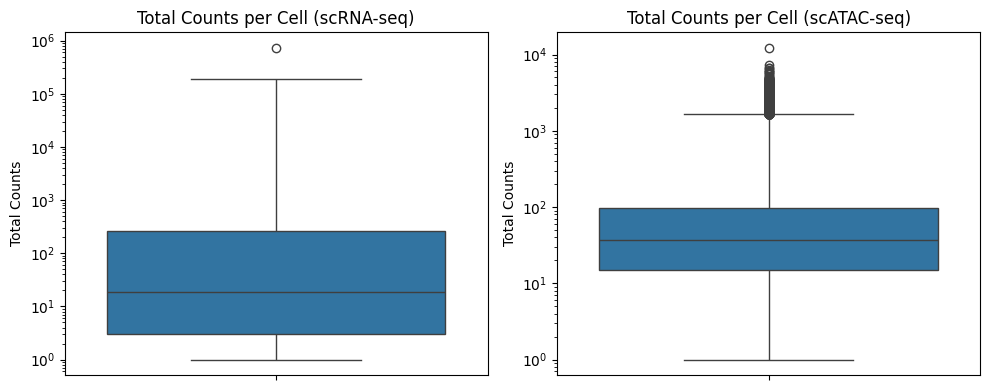

In [5]:
# Calculate total counts per cell for scRNA-seq data
adata_rna.obs['total_counts'] = adata_rna.X.sum(axis=1)

# Calculate total counts per cell for scATAC-seq data
adata_atac.obs['total_counts'] = adata_atac.X.sum(axis=1)

# Plot box plots for scRNA-seq data
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(y=adata_rna.obs['total_counts'], log_scale=True)
plt.title('Total Counts per Cell (scRNA-seq)')
plt.ylabel('Total Counts')

# Plot box plots for scATAC-seq data
plt.subplot(1, 2, 2)
sns.boxplot(y=adata_atac.obs['total_counts'], log_scale=True)
plt.title('Total Counts per Cell (scATAC-seq)')
plt.ylabel('Total Counts')
plt.tight_layout()
plt.show()

**Boxplot Interpretation:**

- scRNA-seq data plot shows a single outlier, suggesting a cell with unusually high gene expression.
- scATAC-seq plot has multiple outliers, indicating variability in chromatin accessibility across cells

**Next Step:**

To better visualize distribution patterns, we apply log transformation and generate violin plots, to provide a more detailed view of data spread for both scRNA-seq and scATAC-seq.

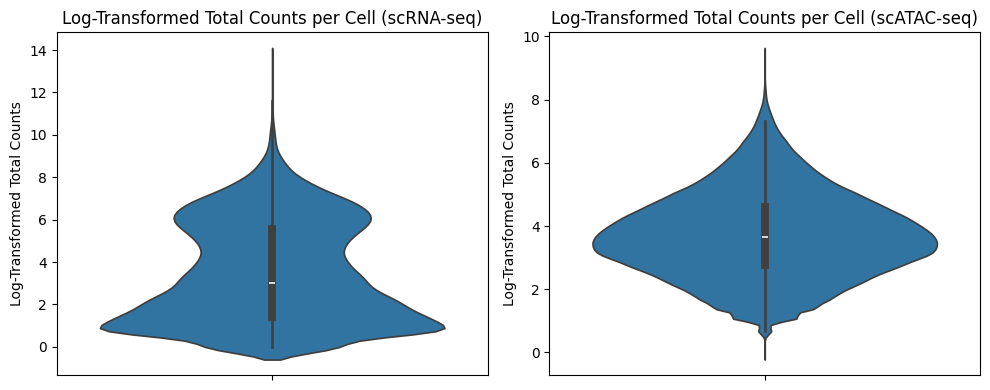

In [6]:
# Calculate total counts per cell for scRNA-seq data
adata_rna.obs['total_counts'] = adata_rna.X.sum(axis=1)

# Calculate total counts per cell for scATAC-seq data
adata_atac.obs['total_counts'] = adata_atac.X.sum(axis=1)

# Log-transform the total counts and remove infs and NaNs
adata_rna.obs['log_total_counts'] = np.log1p(adata_rna.obs['total_counts']).replace([np.inf, -np.inf], np.nan).dropna()
adata_atac.obs['log_total_counts'] = np.log1p(adata_atac.obs['total_counts']).replace([np.inf, -np.inf], np.nan).dropna()

# Plot violin plots for scRNA-seq data
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.violinplot(y=adata_rna.obs['log_total_counts'])
plt.title('Log-Transformed Total Counts per Cell (scRNA-seq)')
plt.ylabel('Log-Transformed Total Counts')

# Plot violin plots for scATAC-seq data
plt.subplot(1, 2, 2)
sns.violinplot(y=adata_atac.obs['log_total_counts'])
plt.title('Log-Transformed Total Counts per Cell (scATAC-seq)')
plt.ylabel('Log-Transformed Total Counts')
plt.tight_layout()
plt.show()

In [7]:
if adata_rna.shape[0] != len(barcodes_rna):
    adata_rna = adata_rna.T  # Transpose if misaligned
if adata_atac.shape[0] != len(barcodes_atac):
    adata_atac = adata_atac.T    # Transpose if misaligned

Ensure barcodes match between scRNA-seq and scATAC-seq and create a MuData object for multi-omics analysis.

A MuData object is a data structure used in Muon package for multi-omics integration.

In [8]:
# Create AnnData objects
adata_rna.obs_names = barcodes_rna[0].values
adata_rna.var_names = genes_rna[0].values

adata_atac.obs_names = barcodes_atac[0].values
adata_atac.var_names = peaks_atac[0].values

# Ensure barcodes match between scRNA-seq and scATAC-seq
common_barcodes = adata_rna.obs_names.intersection(adata_atac.obs_names)
adata_rna = adata_rna[adata_rna.obs_names.isin(common_barcodes), :].copy()  # Create a copy
adata_atac = adata_atac[adata_atac.obs_names.isin(common_barcodes), :].copy()  # Create a copy

# Create a MuData object for multi-omics analysis
mdata = mu.MuData({'rna': adata_rna, 'atac': adata_atac})

a:\Users\steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\mudata\_core\mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
a:\Users\steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\mudata\_core\mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


## Multi-omics Analysis

Perform multi-omics analysis, including preprocessing, dimensionality reduction, and clustering:

In [9]:
# Perform multi-omics analysis
mu.pp.intersect_obs(mdata)

# Apply scanpy preprocessing functions to each modality
for modality in mdata.mod.keys():
    sc.pp.log1p(mdata[modality])
    sc.pp.scale(mdata[modality], max_value=10)
    sc.pp.pca(mdata[modality], svd_solver='arpack')
    sc.pp.neighbors(mdata[modality], n_neighbors=10, n_pcs=40)

# Ensure neighbors are computed for the integrated data
mu.pp.neighbors(mdata)

# Perform UMAP on the integrated data
mu.tl.umap(mdata)

a:\Users\steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\mudata\_core\mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
a:\Users\steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\mudata\_core\mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


## Clustering and Visualization

We will use 2 machine learning to visualize and interpret our multi-omics data, Leiden and UMAP.

First we apply the **Leiden clustering algorithm** to partition cells into distinct populations.
 
- Leiden detects biologically meaningful **clusters in high-dimensional space** before dimensionality reduction.
- This ensures cells are grouped accurately based on their transcriptomic and chromatin accessibility features.
- These clusters appear in the **UMAP visualization**, which we will perform next, to show relationships between populations.

In [10]:
# Compute clusters using the Leiden algorithm if no metadata is available
mu.tl.leiden(mdata)

Finally, we apply **UMAP** to visualize cell distributions.

UMAP (Uniform Manifold Approximation and Projection) is a unsupervised machine learning model that project the high-dimensional data into a 2D space for visualization.  Each point is a cell, and color indicates cluster membership. Cells in the same cluster are transcriptionally and epigenetically similar."

**Key Role of UMAP**  
- Preserves local and global structure in multi-omics datasets.  
- Highlights relationships between transcriptomic and epigenomic features.  
- Visualizes pre-computed **Leiden clusters**, helping interpret cellular diversity.  

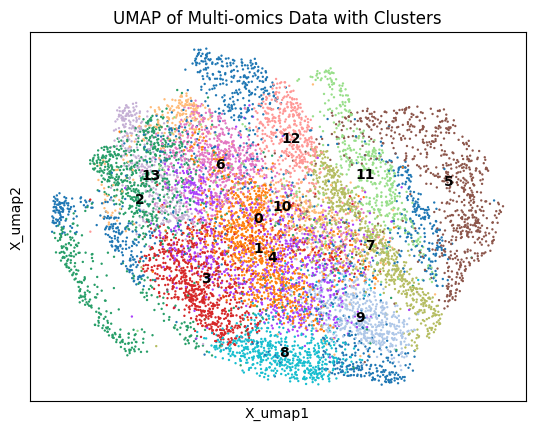

In [11]:

# Visualize with improved labels, coloring by clusters
mu.pl.umap(mdata, color='leiden', legend_loc='on data', legend_fontsize=10, title='UMAP of Multi-omics Data with Clusters', show=True)

**UMAP Interpretation:**
* The plot shows 16 clusters, each representing a different cell type or state.  
* Clusters closer together share similar transcriptomic and chromatin accessibility profiles.  
* This analysis helps uncover cell-type relationships and regulatory mechanisms.  